In [22]:
import sys
import os

%load_ext autoreload
%autoreload 2

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

# Import the MatLab prior work
from other_algs.teralasso import TeraLasso, TeraLasso_cov
from other_algs.EiGLasso import EiGLasso

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Data Processing
import numpy as np

# Loading data
import os

# Plotting
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Our code
from regularizers import *
from GmGM import GmGM
from coil_20_utilities import shuffle_axes, reconstruct_axes, get_accuracies
from utilities import *
from nonparanormal_skeptic import nonparanormal_tensor_skeptic

# To measure runtime
import timeit

# Load in the data

(128, 128, 72)


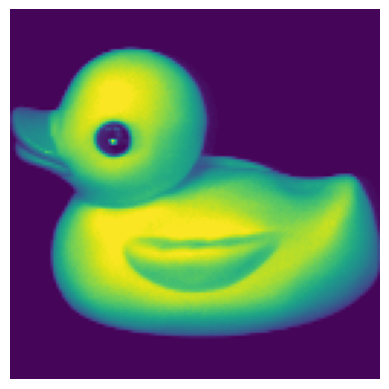

In [24]:
# Find all the files in the data directory
data_dir = os.path.join(os.getcwd(), '../data/coil-20-proc')
files = os.listdir(data_dir)
k = 1

# Format of the duck video is "obj1__{frame}.png"
# We want to grab all files beginning with obj{k}__
files = [f for f in files if f.startswith(f'obj{k}__')]

# And now we want to sort by frame number
def get_frame_number(filename):
    return int(filename.split('__')[1].split('.')[0])

# Sort the files by frame number
files.sort(key=get_frame_number)

# Load them all into a single 3D numpy array
# We'll use the first image to get the shape
first_image = plt.imread(os.path.join(data_dir, files[0]))
image_shape = first_image.shape
image_shape = (image_shape[0], image_shape[1], len(files))

# Now we can allocate the array
images = np.zeros(image_shape)

# And load the images
for i, f in enumerate(files):
    images[:, :, i] = plt.imread(os.path.join(data_dir, f))

print(images.shape)

fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(images[..., 0], cmap='viridis')

(128, 128, 72)


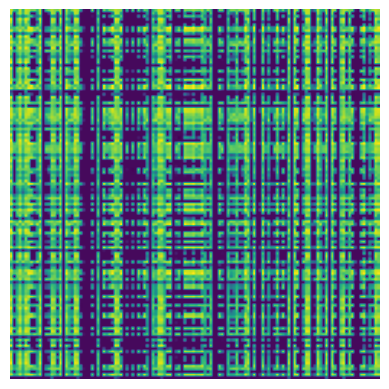

In [25]:
shuffled = shuffle_axes(images, [0, 1, 2])
print(shuffled.shape)

# Plot the shuffled data
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(shuffled[..., 0], cmap='viridis')
fig.savefig("../out_figs/shuffled-duck.png")
fig.savefig("../out_figs/shuffled-duck.svg")

# Experiment 1: GmGM Raw Data

GmGM  [0.875, 0.9375, 0.9305555555555556]


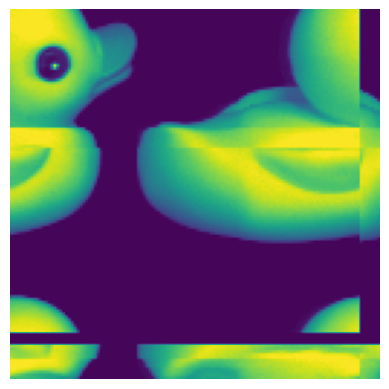

In [5]:
# Run GmGM on it
precisions = GmGM(
    {'video': shuffled - shuffled.mean()},
    {'video': ('row', 'column', 'frame')},
)

# Recover the axes
orders = reconstruct_axes(
    shuffled,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

# Reconstruct the video
unshuffled = shuffled[orders[0]][:, orders[1]][:, :, orders[2]]

# Display the unshuffled video
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(unshuffled[:, :, 0], cmap='viridis')
fig.savefig('../out_figs/gmgm-duck.png')
fig.savefig('../out_figs/gmgm-duck.svg')

# Run GmGM on unshuffled to calculate accuracy
precisions = GmGM(
    {'video': images - images.mean()},
    {'video': ('row', 'column', 'frame')},
)

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("GmGM ", get_accuracies(orders))

## Experiment 1b: Runtime GmGM Raw

In [17]:
def to_time() -> None:
    precisions = GmGM(
        {'video': images - images.mean()},
        {'video': ('row', 'column', 'frame')},
    )

np.mean(timeit.repeat(to_time, number=1, repeat=10))

0.04397104989984655

# Experiment 2: TeraLasso Raw Data

TeraLasso [0.875, 0.9375, 0.9305555555555556]


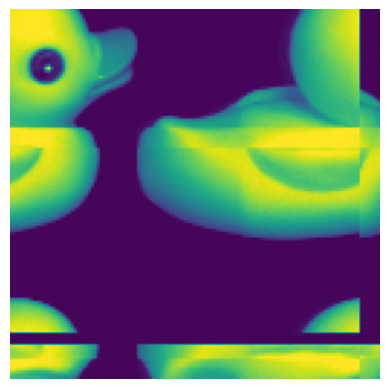

In [6]:
# Run GmGM on it
precisions = TeraLasso(
    (shuffled - shuffled.mean())[np.newaxis, ...],
    betas=[0., 0., 0.]
)
precisions = {
    "row": precisions[0],
    "column": precisions[1],
    "frame": precisions[2],
}

# Recover the axes
orders = reconstruct_axes(
    shuffled,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

# Reconstruct the video
unshuffled = shuffled[orders[0]][:, orders[1]][:, :, orders[2]]

# Display the unshuffled video
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(unshuffled[:, :, 0], cmap='viridis')
fig.savefig('../out_figs/tera-duck.png')
fig.savefig('../out_figs/tera-duck.svg')

# Run GmGM on unshuffled to calculate accuracy
precisions = TeraLasso(
    (images - images.mean())[np.newaxis, ...],
    betas=[0., 0., 0.]
)
precisions = {
    "row": precisions[0],
    "column": precisions[1],
    "frame": precisions[2],
}

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("TeraLasso", get_accuracies(orders))

## Experiment 2b: Runtime TeraLasso Raw

In [18]:
def to_time() -> None:
    precisions = TeraLasso(
        (shuffled - shuffled.mean())[np.newaxis, ...],
        betas=[0., 0., 0.]
    )

np.mean(timeit.repeat(to_time, number=1, repeat=10))

33.085131662499045

# Experiment 3: GmGM with Nonparanormal Skeptic

GmGM  [0.9921875, 0.9921875, 0.9861111111111112]


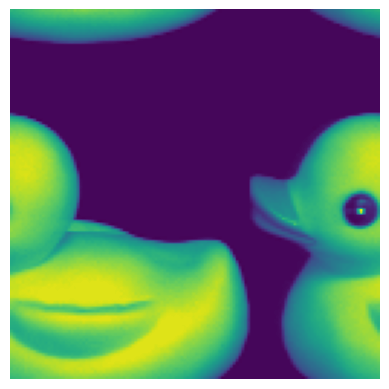

In [7]:
# Run GmGM on it
nonpara_shuff = nonparanormal_tensor_skeptic(shuffled - shuffled.mean(), batchless=True)
precisions = GmGM(
    {'video': shuffled},
    {'video': ('row', 'column', 'frame')},
    gram_matrices = {
        'row': nonpara_shuff[0],
        'column': nonpara_shuff[1],
        'frame': nonpara_shuff[2]
    }
)

# Recover the axes
orders = reconstruct_axes(
    shuffled,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

# Reconstruct the video
unshuffled = shuffled[orders[0]][:, orders[1]][:, :, orders[2]]

# Display the unshuffled video
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(unshuffled[:, :, 0], cmap='viridis')
fig.savefig('../out_figs/gmgm-duck-nonpara.png')
fig.savefig('../out_figs/gmgm-duck-nonpara.svg')

# Run GmGM on unshuffled to calculate accuracy
nonpara = nonparanormal_tensor_skeptic(images - images.mean(), batchless=True)
precisions = GmGM(
    {'video': images},
    {'video': ('row', 'column', 'frame')},
    gram_matrices = {
        'row': nonpara[0],
        'column': nonpara[1],
        'frame': nonpara[2]
    }
)

# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("GmGM ", get_accuracies(orders))

## Experiment 3b: Runtime GmGM Nonparanormal

In [19]:
def to_time() -> None:
    nonpara_shuff = nonparanormal_tensor_skeptic(shuffled - shuffled.mean(), batchless=True)
    precisions = GmGM(
        {'video': shuffled},
        {'video': ('row', 'column', 'frame')},
        gram_matrices = {
            'row': nonpara_shuff[0],
            'column': nonpara_shuff[1],
            'frame': nonpara_shuff[2]
        }
    )

np.mean(timeit.repeat(to_time, number=1, repeat=10))

0.23080212920103804

## Experiment 3c: Runtime without nonparanormal included in time

In [26]:
def to_time() -> None:
    precisions = GmGM(
        {'video': shuffled},
        {'video': ('row', 'column', 'frame')},
        gram_matrices = {
            'row': nonpara_shuff[0],
            'column': nonpara_shuff[1],
            'frame': nonpara_shuff[2]
        }
    )
nonpara_shuff = nonparanormal_tensor_skeptic(shuffled - shuffled.mean(), batchless=True)
np.mean(timeit.repeat(to_time, number=1, repeat=10))

0.04215335409680847

# Experiment 4: TeraLasso Nonparanormal

TeraLasso  [0.9921875, 0.9921875, 0.9861111111111112]


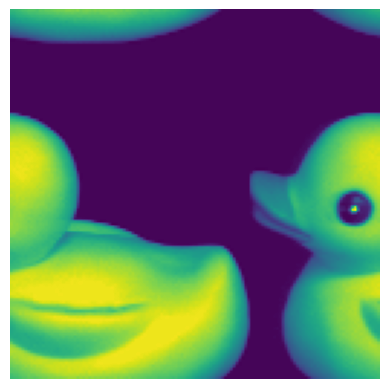

In [8]:
# Run GmGM on it
nonpara_shuff = nonparanormal_tensor_skeptic(shuffled - shuffled.mean(), batchless=True)
precisions = TeraLasso_cov(nonpara_shuff, betas=[0., 0., 0.])
precisions = {
    "row": precisions[0],
    "column": precisions[1],
    "frame": precisions[2],
}

# Recover the axes
orders = reconstruct_axes(
    shuffled,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

# Reconstruct the video
unshuffled = shuffled[orders[0]][:, orders[1]][:, :, orders[2]]

# Display the unshuffled video
fig, ax = plt.subplots()
ax.set_axis_off()
im = ax.imshow(unshuffled[:, :, 0], cmap='viridis')
fig.savefig('../out_figs/tera-duck-nonpara.png')
fig.savefig('../out_figs/tera-duck-nonpara.svg')

# Run GmGM on unshuffled to calculate accuracy
nonpara = nonparanormal_tensor_skeptic(images - images.mean(), batchless=True)
precisions = TeraLasso_cov(nonpara, betas=[0., 0., 0.])
precisions = {
    "row": precisions[0],
    "column": precisions[1],
    "frame": precisions[2],
}
# "Reconstruct"
orders = reconstruct_axes(
    images,
    [0, 1, 2],
    [
        np.abs(precisions["row"]),
        np.abs(precisions["column"]),
        np.abs(precisions["frame"]),
    ]
)

print("TeraLasso ", get_accuracies(orders))

## Experiment 4b: Runtime TeraLasso Nonparanormal

In [20]:
def to_time() -> None:
    nonpara_shuff = nonparanormal_tensor_skeptic(shuffled - shuffled.mean(), batchless=True)
    precisions = TeraLasso_cov(nonpara_shuff, betas=[0., 0., 0.])

np.mean(timeit.repeat(to_time, number=1, repeat=10))

5.171376995898754